# This script is for distinguishing chaotic behavior and noise in a given time series
### more specifically, we test on data in Mexico, England and Wales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from helper_function_obtain_data import *
import sys
import seaborn as sns
from scipy.interpolate import CubicSpline
import csv
import CCM
import sklearn
import scipy
from sklearn.neighbors import NearestNeighbors
import random

First method (Simplex forecasting) proposed in Nonlinear forecasting as a way of distinguishing chaos from measurement error in time series

In [8]:
class Embed:
    """
    Implements time-embedding of a time series X

    """
    def __init__(self, X):
        self.X = X

    def embed_vectors(self, tau, E):

        N_ts = self.X.shape[0] # length of time series
        shadow_manifold = np.zeros((N_ts - tau*(E-1), E))

        for i in range(shadow_manifold.shape[0]):
            shadow_manifold[i,:] = self.X[i:i+tau*(E-1)+1:tau]

        return shadow_manifold

class simplex:
    """
    construct \hat{x_t}|M_y, cross-mapped estimate of x_t
    """

    def __init__(self, E, X, Mx, tau):
        self.E = E # embedding dimension
        self.tau = tau
        self.X = X
        # self.X_test = X_test
        self.Mx = Mx


    def one_forecasting_no_drop(self, Tp, predicting_ind):

        """
        Tp step ahead forecasting for one row in Mx (predicting_ind picks the row index)
        Input: Tp: represent how many time steps we want to predict in the future
               predicting_ind: which row in Mx that we aim to predict its future values
        """

        # find E+1 nearest neights of x_t in Mx
        num_nn = self.E + 1
        N = self.Mx.shape[0]
        
        # Note that the reason using every row in Mx except the last one is because we can't predict using
        # the last row.
        nbrsX = NearestNeighbors(n_neighbors = num_nn+1, algorithm = 'auto').fit(self.Mx[:-1,:])
        distances, indices = nbrsX.kneighbors(self.Mx[:-1,:])

        # remove the first nn, because the closest one is always itself
        # indices will have the shape (Mx.shape[0], num_nn)
        # ith row in indices (shape (1, num_nn)) contains the row number in Mx of its n.n.
        indices = indices[:,1:]


        for i in [predicting_ind]:
            y = self.Mx[i,:] # targeted data point to be predicted
            # extract nearest neighbor for y
            nn_ind = indices[i,:] # the row number in Mx of y's n.n.
            nn_y = self.Mx[nn_ind, :] # y's n.n., nn_y has shape (num_nn, self.E)
            # compute weights
            dist_y = distances[i,1:] # distance of num_nn many n.n. from y
            d = dist_y[0]
            epsilon = 0.0001 # avoid dividing by 0 when computing Weights
            Weights = np.exp(-dist_y/(d+epsilon)) # of shape (1, num_nn)
            Weights = Weights/np.sum(Weights) # normalization

            # extract the Tp step ahead points in each nearest neighbors of y
            pred_nn = np.zeros((num_nn, Tp)) # store points at Tp step ahead in n.n. of y
            for j in range(num_nn):
                # compute the index of the ith nearest neighbor 
                ind = nn_ind[j]
                # compute the data index of the last entry in nn_y(ind, :), the ind^th n.n. of y
                last_ind = ind + (self.E-1)*self.tau 
                pred_nn[j,:] = self.X[last_ind+1:last_ind+Tp+1]

            # compute the weighted prediction
            y_pred = np.matmul(Weights, pred_nn)
            # extract the actual Tp step ahead points of y
            last_ind_y = i + (self.E-1)*self.tau 
            y_actual_ind = range(last_ind+1,last_ind+Tp+1)
            
        # combine output dictionary
        cache = {'prediction': y_pred, 'actual data indices': y_actual_ind, 'nearest neighbors': nn_y,
                'nearest neighbors indices': nn_ind}
        
        return cache
        
    def one_forecasting_drop(self, Tp, predicting_ind):

        """
        This function drops the nearest neighbors that we find for the targeted data have conflicting
        indices with the targeted data
        Tp step ahead forecasting for one row in Mx (predicting_ind picks the row index)
        Input: Tp: represent how many time steps we want to predict in the future
               predicting_ind: which row in Mx that we aim to predict its future values
        """

        # find E+1 nearest neights of x_t in Mx
        num_nn = self.E + 1
        N = self.Mx.shape[0]
        
        # Note that the reason using every row in Mx except the last one is because we can't predict using
        # the last row.
        nbrsX = NearestNeighbors(n_neighbors = N-1, algorithm = 'auto').fit(self.Mx[:-1,:])
        distances, ind = nbrsX.kneighbors(self.Mx[:-1,:])

        # remove the first nn, because the closest one is always itself
        # indices will have the shape (Mx.shape[0], N-1)
        # ith row in indices (shape (1, N-1)) contains the row number in Mx of its n.n.
        ind = ind[:,1:]
   
        for i in [predicting_ind]:
            y = self.Mx[i,:] # targeted data point to be predicted
            # extract nearest neighbor for y
            nn_ind = indices[i,:] # the row number in Mx of y's n.n.
            nn_y = self.Mx[nn_ind, :] # y's n.n., nn_y has shape (num_nn, self.E)
            # compute weights
            dist_y = distances[i,1:] # distance of num_nn many n.n. from y
            d = dist_y[0]
            epsilon = 0.0001 # avoid dividing by 0 when computing Weights
            Weights = np.exp(-dist_y/(d+epsilon)) # of shape (1, num_nn)
            Weights = Weights/np.sum(Weights) # normalization

            # extract the Tp step ahead points in each nearest neighbors of y
            pred_nn = np.zeros((num_nn, Tp)) # store points at Tp step ahead in n.n. of y
            for j in range(num_nn):
                # compute the index of the ith nearest neighbor 
                ind = nn_ind[j]
                # compute the data index of the last entry in nn_y(ind, :), the ind^th n.n. of y
                last_ind = ind + (self.E-1)*self.tau 
                pred_nn[j,:] = self.X[last_ind+1:last_ind+Tp+1]

            # compute the weighted prediction
            y_pred = np.matmul(Weights, pred_nn)
            # extract the actual Tp step ahead points of y
            last_ind_y = i + (self.E-1)*self.tau 
            y_actual_ind = range(last_ind+1,last_ind+Tp+1)
            
        # combine output dictionary
        cache = {'prediction': y_pred, 'actual data indices': y_actual_ind, 'nearest neighbors': nn_y,
                'nearest neighbors indices': nn_ind}
        
    def forecasting(self, Tp):

        """
        Tp step ahead forecasting for one row in Mx (predicting_ind picks the row index)
        Input: Tp: represent how many time steps we want to predict in the future
        """

        # find E+1 nearest neights of x_t in Mx
        num_nn = self.E + 1
        N = self.Mx.shape[0]
        
        # Note that the reason using every row in Mx except the last one is because we can't predict using
        # the last row.
        nbrsX = NearestNeighbors(n_neighbors = num_nn+1, algorithm = 'auto').fit(self.Mx[:-1,:])
        distances, indices = nbrsX.kneighbors(self.Mx[:-1,:])

        # remove the first nn, because the closest one is always itself
        # indices will have the shape (Mx.shape[0], num_nn)
        # ith row in indices (shape (1, num_nn)) contains the row number in Mx of its n.n.
        indices = indices[:,1:]

        
        y_actual_list = []
        y_pred_list = []
        for i in range(1,N-1,1):
            y = self.Mx[i,:] # targeted data point to be predicted
            # extract nearest neighbor for y
            nn_ind = indices[i,:] # the row number in Mx of y's n.n.
            nn_y = self.Mx[nn_ind, :] # y's n.n., nn_y has shape (num_nn, self.E)
            # compute weights
            dist_y = distances[i,1:] # distance of num_nn many n.n. from y
            d = dist_y[0]
            epsilon = 0.0001 # avoid dividing by 0 when computing Weights
            Weights = np.exp(-dist_y/(d+epsilon)) # of shape (1, num_nn)
            Weights = Weights/np.sum(Weights) # normalization

            # extract the Tp step ahead points in each nearest neighbors of y
            pred_nn = np.zeros((num_nn, Tp)) # store points at Tp step ahead in n.n. of y
            for j in range(num_nn):
                # compute the index of the ith nearest neighbor 
                ind = nn_ind[j]
                # compute the data index of the last entry in nn_y(ind, :), the ind^th n.n. of y
                last_ind = ind + (self.E-1)*self.tau 
                pred_nn[j,:] = self.X[last_ind+1:last_ind+Tp+1]

            # compute the weighted prediction
            y_pred = np.matmul(Weights, pred_nn)
            y_pred_list.append(y_pred)
            # extract indices the actual Tp step ahead points of y in X
            last_ind_y = i + (self.E-1)*self.tau 
            y_actual_ind = range(last_ind+1,last_ind+Tp+1)
            y_actual = self.X[y_actual_ind]
            y_actual_list.append(y_actual)
            
        # combine output dictionary
        cache = {'prediction list': y_pred_list, 'actual data list': y_actual_list}

        return cache

In [20]:
# Tp steps ahead prediction for one row in Mx
def prediction_one_point(state, tau, predicting_ind, E, interpolate=False, plotting=False):
    """  
    Visualize how nearest neighbors look like using SIMPLEX projection method
    E: embedding dimension
    predicting_ind: which row in Mx that we aim to predict its future values
    """
    ## Obtain data
    disease = 'rubella'
    t, locations, tot_data, data_dic = preprocess_Mexico_disease_data(disease)
    x = data_dic[state] # causal variable, to be constructed
    start_year = 1986
    start_year_num = start_year - 1985 - 1
    start_month = 1
    start_time_ind = start_year_num*12 + start_month - 1
    end_year = 2008
    end_year_num = end_year - 1985 - 1
    end_month = 12
    end_time_ind = end_year_num*12 + end_month - 1
    t = t[start_time_ind:end_time_ind:1]
    X = x[start_time_ind:end_time_ind:1] # chop the series at month/year

    # interpolate data using cubic spline
    if interpolate:
        dt = 0.4 # finer time step size
        t_finer = np.arange(0, len(X), dt) # finer time array
        cs = CubicSpline(t, X)
        X = cs(t_finer)
        t = t_finer
    
    Tp = 1 # how many time steps to forecast in the future
    # generate embedding using the 1D time series
    eX = Embed(X) 
    Mx = eX.embed_vectors(tau,E) # shadow manifold of x
    simplex_pred = simplex(E, X, Mx, tau)
    cache = simplex_pred.one_forecasting_no_drop(Tp, predicting_ind)
    print(eX)
    y_pred = cache['prediction']
    y_actual_ind = cache['actual data indices']
    y_actual = X[y_actual_ind]
    t_pred = t[y_actual_ind] # time plotted with y_actual and y_pred
    
    y = Mx[predicting_ind,:] # targeted data to be predicted Tp ahead
    ty = t[predicting_ind:predicting_ind + (E-1)*tau + 1:tau] # time plotted with y
    
    nn_ind = cache['nearest neighbors indices']
    nn_y = Mx[nn_ind, :] # y's nearest neighbors
    t_nn = np.array([t[ind:ind+(E-1)*tau+1:tau] for ind in nn_ind])   
    
    # plotting  
    if plotting:
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.figure(0)
        plt.plot(t, X)
        plt.plot(ty, y, 'bo', markersize = 10)
        plt.xlabel("Time",fontsize=20)
        plt.ylabel("Incidence",fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig("target.pdf", bbox_inches="tight")
        plt.figure(1)
        plt.plot(t, X)
        plt.plot(ty, y, 'bo', markersize = 10)
        for i in range(nn_y.shape[0]):
            plt.plot(t_nn[i,:], nn_y[i, :], '*', markersize = 15, label = 'nearest neighbors')
        plt.xlabel("Time",fontsize=20)
        plt.ylabel("Incidence",fontsize=20)
        plt.legend(loc=2, fontsize = 'xx-large')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig("nn.pdf", bbox_inches="tight")
        plt.figure(2)
        plt.plot(y, 'bo-', markersize = 10)
        plt.plot(np.transpose(nn_y), '*-')
        plt.plot(np.array(range(Tp))+len(y), y_pred, 'r*', markersize = 20)
        plt.plot(np.array(range(Tp))+len(y), y_actual, 'ro', markersize = 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig("pred.pdf", bbox_inches="tight")
    return y_actual, y_pred


(array([6.]), array([25.52012919]))

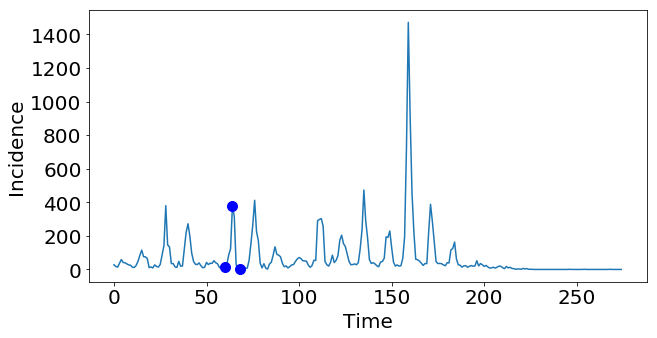

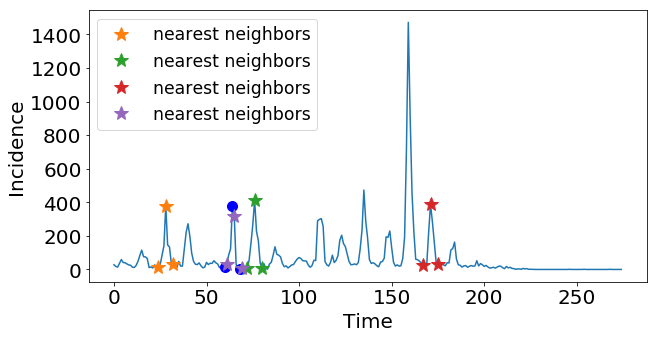

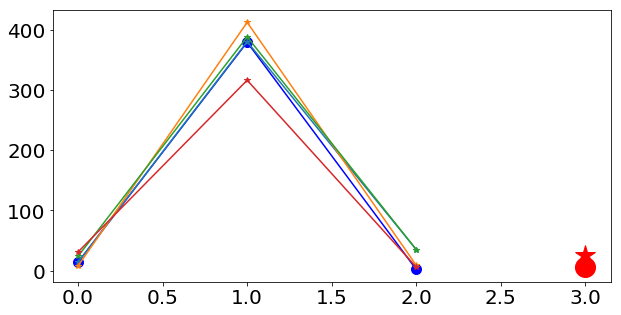

In [21]:
prediction_one_point('Chihuahua', tau=4, predicting_ind=60, E=3, interpolate=False, plotting=True)

In [4]:
# Tp steps ahead prediction for one row in Mx
def prediction(state, tau, E, interpolate=False, plotting=False):
    """  
    E: embedding dimension
    """
    ## Obtain data
    disease = 'rubella'
    t, locations, tot_data, data_dic = preprocess_Mexico_disease_data(disease)
    x = data_dic[state] # causal variable, to be constructed
#     x = tot_data
    start_year = 1986
    start_year_num = start_year - 1985 - 1
    start_month = 1
    start_time_ind = start_year_num*12 + start_month - 1
    end_year = 1996
    end_year_num = end_year - 1985 - 1
    end_month = 12
    end_time_ind = end_year_num*12 + end_month - 1
    t = t[start_time_ind:end_time_ind:1]
    X = x[start_time_ind:end_time_ind:1] # chop the series at month/year

    # interpolate data using cubic spline
    if interpolate:
        dt = 0.5 # finer time step size
        t_finer = np.arange(0, len(X), dt) # finer time array
        cs = CubicSpline(t, X)
        X = cs(t_finer)
        t = t_finer
    
    Tp = 1 # how many time steps to forecast in the future
    # generate embedding using the 1D time series
    eX = Embed(X) 
    Mx = eX.embed_vectors(tau,E) # shadow manifold of x
    
    simplex_pred = simplex(E, X, Mx, tau)
    cache = simplex_pred.forecasting(Tp)
    truth = cache['actual data list']
    prediction = cache['prediction list']
    
    corr_coeff, p_value = scipy.stats.pearsonr(truth, prediction)
    
    
    # plotting  
    if plotting:
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.figure(0)
        plt.plot(t, truth)
        plt.plot(t, prediction)
        
    return corr_coeff

# Finding optimal embedding dimension using Simplex projection and optimal time lag using Mutual Information

In [7]:
# loop through choices of E and tau
E_vec = np.array(range(1,12,1)) # candidates of E, embedding dimension
tau_vec = np.array(range(1,10,1)) # candidates of tau, time delay used to construct the matrix

corr = np.zeros((len(E_vec), len(tau_vec)))
for e_ind in range(len(E_vec)):
    for tau_ind in range(len(tau_vec)):
        corr[e_ind, tau_ind] = prediction('Mexico', tau_vec[tau_ind], E_vec[e_ind])

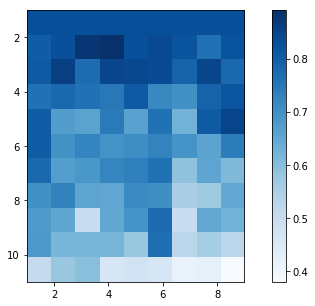

In [8]:
fig = plt.figure(0)
extent = [tau_vec[0], tau_vec[-1], E_vec[-1], E_vec[0]]
fig1 = plt.imshow(corr, cmap='Blues',extent=extent)
fig.colorbar(fig1)

In [9]:
max_ind = np.unravel_index(np.argmax(corr), corr.shape)
E_max = E_vec[max_ind[0]]
tau_max = tau_vec[max_ind[1]]
print(E_max, tau_max)

2 4
